In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import tifffile
from PIL import Image
import os
import numpy as np
import time
import re
from skimage import data, color
import scipy.ndimage as ndimage
import h5py
import scipy.io as spio
import sys
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()
from multiprocessing.dummy import Pool 

sys.path.append('/home/yves/Documents/')
import twoptb as MP



In [2]:
animal_name = 'Road_Runner_GP'
HDF_File,file_path = MP.file_management.create_base_hdf(animal_ID=animal_name,file_loc='/media/yves/Storage 2/' )

File already exists if you proceed you will overwrite 
 are you sure you would like to proceed
type yes if you would like to proceed otherwise press enter
File not overwritten, returning handle to existing file


In [3]:
session_ID = '20160216'

In [4]:
areas = HDF_File[session_ID]['raw_data'].keys()

In [5]:
area_idx = 0
areD_0 = np.array(HDF_File[session_ID]['raw_data'][areas[area_idx]])

In [6]:
def gauss_smooth(inArr):
    return ndimage.gaussian_filter(inArr.astype('float'), sigma=(5, 5), order=0)

In [103]:
#import multiprocessing
#p = multiprocessing.Pool(24)
#area1 = p.map(gauss_smooth,areD_0)

In [7]:
for idx,im in enumerate(areD_0):
    if np.remainder(idx,1000)==0:
        print idx
    areD_0[idx] = ndimage.gaussian_filter(im.astype('float'), sigma=(5, 5), order=0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [8]:
areaD_s = areD_0[:,1::3,1::3]

In [9]:
#from skimage.measure import block_reduce
#st = time.time()
#areaD_s = block_reduce(areD_0[:,1:-1,1:-1], block_size=(1,5,5), func=np.mean)
#print time.time() - st

In [10]:
def smooth_matlab(arr,n=500):
    
    assert np.remainder(n,2)==0, "the filter must be even length"
    ret = np.cumsum(arr,axis=0).astype('float')
    offset = int(n/2)
    ret[offset:-offset] = ret[n:] - ret[:-n]
    ret[offset:-offset] /= n
    ret[:offset] = ret[offset +1]
    ret[-offset:] = ret[-offset-1]
    return ret

In [11]:
#So this does smooth the way you want, I think. Tested by below
# TEST #np.allclose(smooth_matlab(np.array(areaD_s[:,50,43]),n=500),areaD_s_tempF[:,51,43])
st = time.time()
areaD_s_tempF = smooth_matlab(np.array(areaD_s))
print time.time() - st

9.97734999657


In [12]:
areaD_s2 = areaD_s - areaD_s_tempF

(2000, 7000)

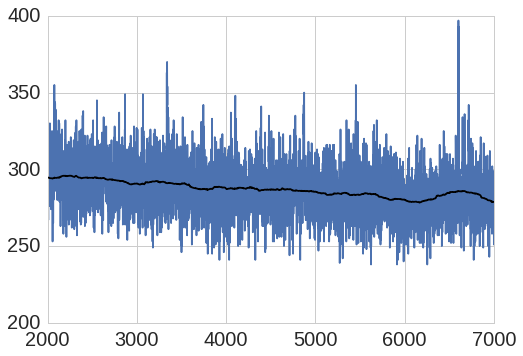

In [13]:
plt.plot(areaD_s_tempF[:,22,18],zorder=10,color='k')
#plt.plot(areaD_s_tempF[:,22,18])
plt.plot(areaD_s[:,22,18])
plt.xlim(2000,7000)

# Now get Design Matrix

In [14]:
ls '/media/yves/Storage 2/Road_Runner_GP/'

Road_Runner_GP.h5*
search_tones_outDat_2016_2_16_17_38_0.mat*
search_tones_outDat_2016_2_16_17_47_30.mat*
search_tones_outDat_2016_2_16_17_58_33.mat*


## Load the Paths

In [15]:
import scipy.io as spio

matFilePaths = ['/media/yves/Storage 2/Road_Runner_GP/search_tones_outDat_2016_2_16_17_38_0.mat',
               '/media/yves/Storage 2/Road_Runner_GP/search_tones_outDat_2016_2_16_17_47_30.mat',
               '/media/yves/Storage 2/Road_Runner_GP/search_tones_outDat_2016_2_16_17_58_33.mat']

matFilePth = matFilePaths[area_idx]

grabI = MP.file_management.load_images.load_GRABinfo(spio.loadmat(matFilePth,struct_as_record=False, squeeze_me=True)['outDat'])

In [16]:
frqs = np.logspace(np.log10(1000),np.log10(80000),num=24)#np.unique(grabI['stimMat'][:,0])
nFreqs = len(frqs)
print nFreqs

24


In [217]:
nFrames = len(grabI['trialOrder'])*grabI['sweepLengthFrames']

In [218]:
#This averages responses to stimuli across levels
#groupedStims = np.floor((grabI['trialOrder']-1)/4)

groupedStims = grabI['trialOrder']

#Code to test this works
#nOccs = [] #number of occurrences
#for i in np.unique(groupedStims):
#    nOccs.append(np.sum(groupedStims==i))
#assert all(np.array(nOccs)==24), "Something went wrong with your extraction"


In [116]:
#np.unique(levels)

In [117]:
#levels = np.remainder((grabI['trialOrder']-1),4)/4 + .25

In [170]:
nFrames = areaD_s.shape[0]

In [180]:
DM = np.zeros([int(np.max(groupedStims)+1),int(nFrames)])

for stim_type in range(int(np.max(groupedStims).astype('int')+1)):
    stimLocs = np.where(groupedStims==stim_type)[0]
    for loc in stimLocs:
        DM[int(stim_type),int(loc*grabI['sweepLengthFrames'])] =1 #levels[loc]/4

In [152]:
from scipy.stats.mstats import zscore
st = time.time()

z_inp = np.zeros(areaD_s2.shape)
for i in range(areaD_s2.shape[1]):
    for j in range(areaD_s2.shape[2]):
        z_inp[:,i,j] = zscore(np.sqrt(areaD_s2[:,i,j]+np.abs(np.min(areaD_s2[:,i,j]))))
#z_inp = zscore(np.sqrt(areaD_s2+np.abs(np.min(areaD_s2))),axis=0)   #square root to normalise count statistics
print time.time() - st

newZ = smooth_matlab(z_inp,6)


11.1359548569


In [181]:
resps = np.zeros([areaD_s.shape[1],
                  areaD_s.shape[2],
                  int(np.max(groupedStims)+1),12])

bF = np.concatenate([np.linspace(.2,1.5,num=7),
                     np.linspace(1.5,1.3,num=4),
                     np.array([1.2,1.1,1,.9,.8,.7,.65,.625,.6,.575,.55,.525,.475,]),
                     np.linspace(.425,0,num=8)])
#bF = np.ones(10)
bF /= np.sum(bF)
for idx in range(DM.shape[0]):
    
    DM[idx] = np.convolve(bF,DM[idx],mode='full')[:-(len(bF)-1)]

for stim_type in range(int(np.max(groupedStims).astype('int'))):
    stimLocs = np.where(groupedStims==stim_type)[0]
    for i,idx in enumerate(stimLocs):
        resps[:,:,int(stim_type),i] = np.mean(z_inp[idx:idx+len(bF)]*bF[:,None,None],axis=0)

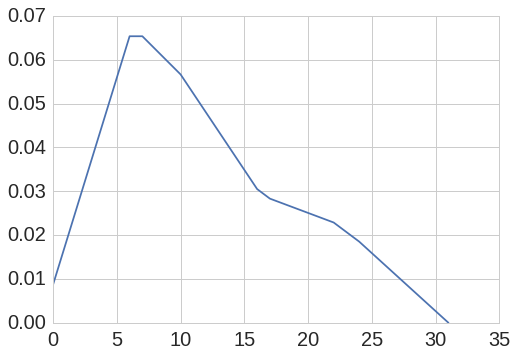

In [182]:
plt.plot(bF)

In [183]:
DM = np.vstack([np.ones(DM.shape[1]),DM])

In [184]:
#inv = np.linalg.inv(DM.T.dot(DM) + np.random.normal(loc=0,scale=.001,size=[13500,13500])).dot(DM.T).T
#inv = np.linalg.inv(DM.dot(DM.T)) # this is not the real thing, this is different
inv2 = np.linalg.inv(DM.dot(DM.T) + np.random.normal(loc=0,scale=1e-48,size=[DM.shape[0],DM.shape[0]])).dot(DM)

In [185]:
#DM = zscore(DM,axis=0)

In [186]:
#newZ = z_inp

(0, 2500)

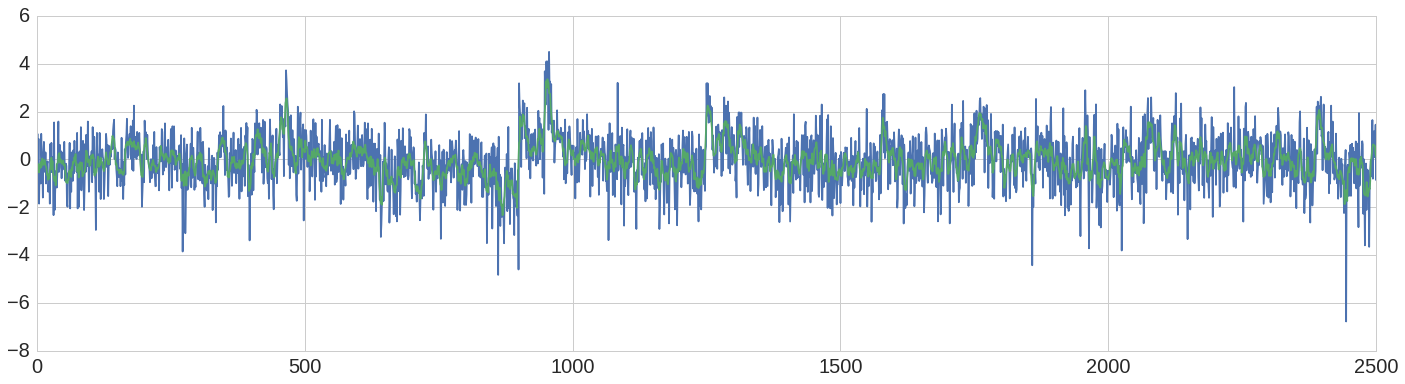

In [187]:
xidx = 32;
yidx=44
plt.figure(figsize=(24,6))
plt.plot(z_inp[:,xidx,yidx])
plt.plot(newZ[:,xidx,yidx])

plt.xlim(0,2500)

In [192]:
final = np.zeros(areaD_s2.shape[1:])
final2 = np.zeros(areaD_s2.shape[1:])

for i in range(final.shape[0]):
    for j in range(final.shape[1]):
        final[i,j] = np.argmax((inv2.dot(newZ[:,i,j])-1)/4)
        #final2[i,j] = np.reshape(inv2.dot(newZ[:,i,j])-1/4)

In [88]:
#final = (final-1)/4

In [89]:
#plt.plot(res.params)
#plt.plot(b)

0.393756068685


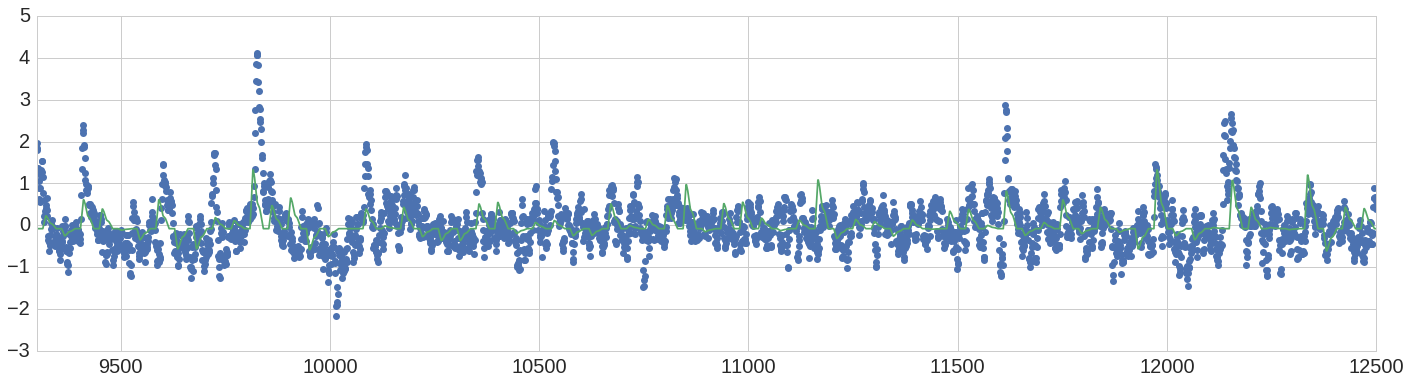

In [216]:
xidx = 76
yidx = 22
b = inv2.dot(newZ[:,xidx,yidx])

plt.figure(figsize=(24,6))
plt.plot(newZ[:,xidx,yidx],'o')
plt.plot(DM.T.dot(b))
plt.xlim(9300,12500)

print np.corrcoef(newZ[:,xidx,yidx],DM.T.dot(b))[0,1]

### Make  a nice little plot

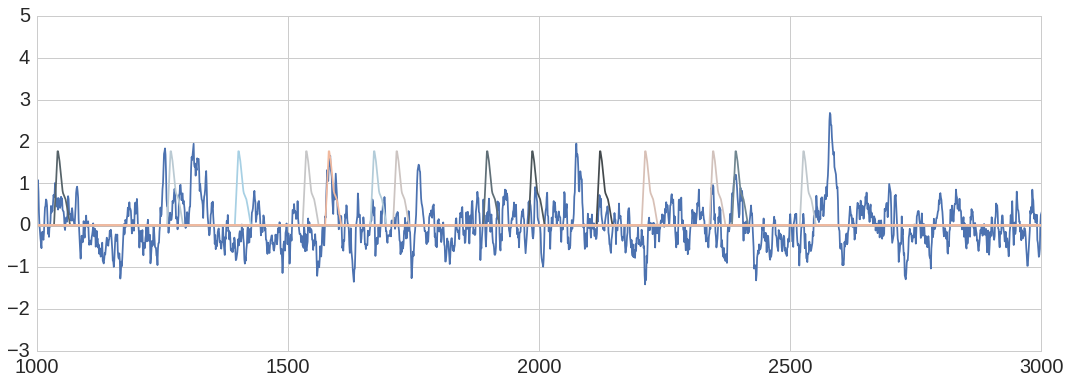

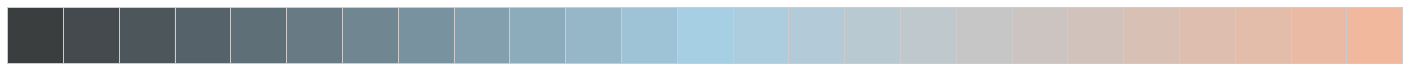

In [199]:
plt.figure(figsize=(18,6))

xidx = 77
yidx = 22
#plt.plot(areaD_s_tempF[:,xidx,yidx],zorder=10,color='k')
#plt.plot(areaD_s_tempF[:,22,18])
#plt.plot(areaD_s[:,xidx,yidx])
plt.plot(newZ[:,xidx,yidx])
clrs = seaborn.color_palette('RdBu_d',n_colors=25)
for clr,i in zip(clrs,DM[1:]):
    stimls = np.where(i)
    plt.plot(4*i*(np.max(newZ[:,xidx,yidx])-np.min(newZ[:,xidx,yidx])) + np.mean(newZ[:,xidx,yidx]),
             color=clr)
    #for i in stimls:
        #plt.vlines(i,np.min(areaD_s[:,43,18]),np.max(areaD_s[:,43,18]),color=clr,linewidth=0.7)
        #plt.plot(i*(np.max(areaD_s[:,43,18])-np.min(areaD_s[:,43,18])) + np.min(areaD_s[:,43,18]))
plt.xlim(1000,3000)

seaborn.palplot(clrs)

In [200]:
"""maxs = np.zeros([areaD_s.shape[1]+1,
                areaD_s.shape[2]+1])
alphas = np.zeros([areaD_s.shape[1]+1,
                  areaD_s.shape[2]+1])
for i in range(areaD_s.shape[1]):
    
    for j in range(areaD_s.shape[2]):
        maxs[i,j] = np.argmax(np.mean(np.squeeze(resps[i,j]),axis=1))
        alphas[i,j] = 1 if (np.max(np.mean(np.squeeze(resps[i,j]),axis=1)) -
                            np.mean(np.mean(np.squeeze(resps[i,j]),axis=1)))>.00 else 0
        """
maxs = final


In [201]:
#maxs = final



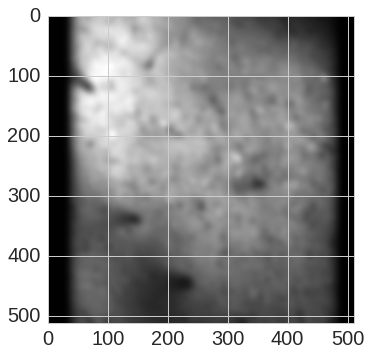

In [209]:
plt.imshow(np.mean(areD_0[:2000],axis=0),cmap='binary_r')

In [202]:
alphas = np.var(newZ,axis=0)

In [205]:
myMatrix =np.ma.masked_where(alphas<.3, maxs)


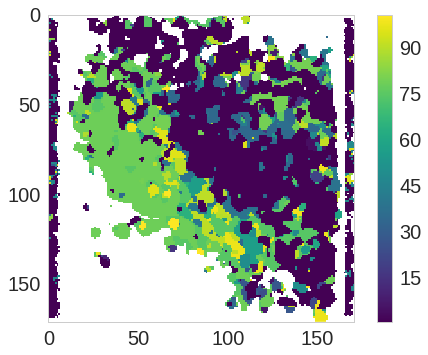

In [207]:
plt.imshow(myMatrix,interpolation='None',cmap='viridis')
plt.grid()
plt.colorbar()

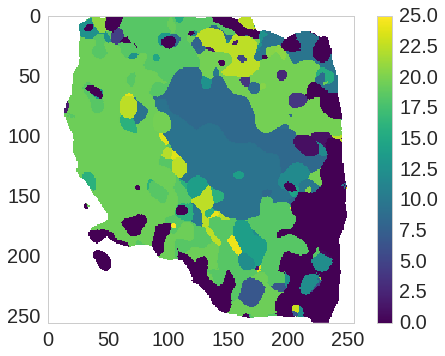

In [58]:
plt.imshow(myMatrix,interpolation='None',cmap='viridis')
plt.grid()
plt.colorbar()

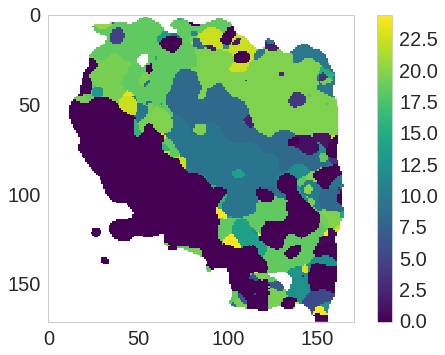

In [47]:
plt.imshow(myMatrix,interpolation='None',cmap='viridis')
plt.grid()
plt.colorbar()

In [63]:
from time import sleep
import sys

rg = 1350

maxN = 100

pFac = rg/maxN
for i in range(rg):
    sys.stdout.write('\r')
    # the exact output you're looking for:
    pStr = r"[%-100s] %d%%" 
    sys.stdout.write(pStr % ('.'*int(np.round(i/pFac)), 5))
    sys.stdout.flush()
    sleep(0.0001)

[....................................................................................................] 5%

In [64]:
102/13500

0.007555555555555556